In [1]:
#!pip install statsforecast --upgrade

!pip install git+https://github.com/Nixtla/statsforecast.git

  Cloning https://github.com/Nixtla/statsforecast.git to /tmp/pip-req-build-giu9i7of
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/statsforecast.git /tmp/pip-req-build-giu9i7of
  Resolved https://github.com/Nixtla/statsforecast.git to commit 5d7c1ac118a2a245334e20a75d665570f2eccb6c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.7/293.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.8 MB/s eta 0:00:00
  Created wheel for statsforecast:

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from statsforecast import StatsForecast

from statsforecast.models import SeasonalExponentialSmoothing, ADIDA, ARIMA
from statsforecast.utils import ConformalIntervals

import matplotlib.pyplot as plt

from statsforecast.models import (
    AutoETS,
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive
)

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
!pip show statsforecast

Name: statsforecast
Version: 1.5.0
Summary: Time series forecasting suite using statistical models
Home-page: https://github.com/Nixtla/statsforecast/
Author: Nixtla
Author-email: business@nixtla.io
License: Apache Software License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fugue, matplotlib, numba, numpy, pandas, polars, scipy, statsmodels, tqdm
Required-by: 


In [4]:
import statsforecast.utils
dir(statsforecast.utils)

['AirPassengers',
 'AirPassengersDF',
 'ConformalIntervals',
 'Union',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_calculate_intervals',
 '_calculate_sigma',
 '_naive',
 '_quantiles',
 '_repeat_val',
 '_repeat_val_seas',
 '_seasonal_naive',
 'generate_series',
 'njit',
 'norm',
 'np',
 'pd',
 'pl',
 'random']

## Load the dataset

In [5]:
# Load the dataset, we will use the hourly dataset from the M4 Competition
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [6]:
train.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

In [7]:
test.head()

unique_id   ds  y_test
0        H1  701   619.0
1        H1  702   565.0
2        H1  703   532.0
3        H1  704   495.0
4        H1  705   481.0

## Train the models

In [8]:
# we will only use the first 8 series of the dataset to reduce the total computational time.
n_series = 8
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

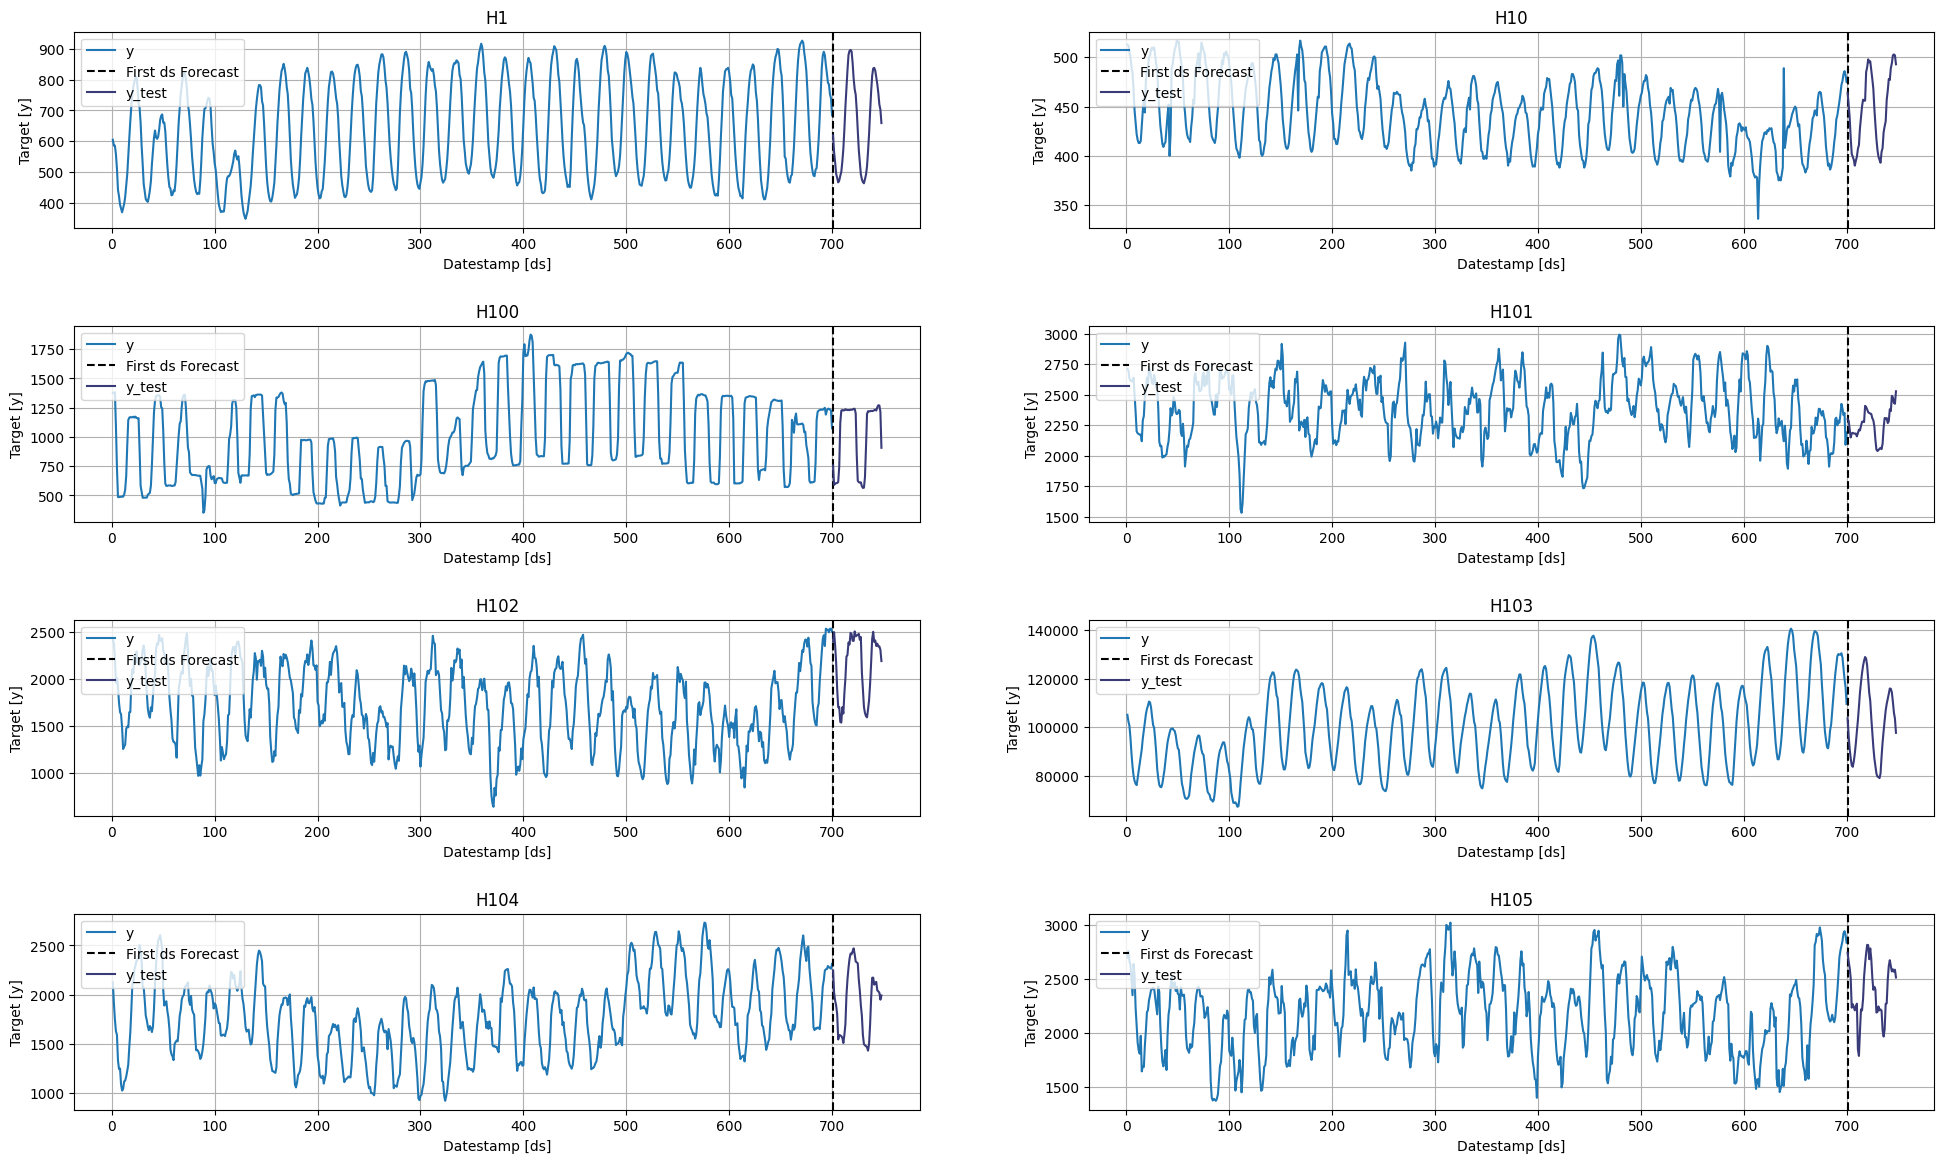

In [9]:
StatsForecast.plot(train, test, plot_random = False)

In [10]:
# Create a list of models and instantiation parameters
# To use these models, we first need to import them from statsforecast.models and then we need to instantiate them.
# Given that we’re working with hourly data, we need to set seasonal_length=24 in the models that requirere this parameter.
models = [
    AutoETS(season_length=24),
    HistoricAverage(),
    Naive(),
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=24)
]

In [11]:
# To instantiate a new StatsForecast object, we need the following parameters:
# df: The dataframe with the training data.
# models: The list of models defined in the previous step.
# freq: A string indicating the frequency of the data. See pandas’ available frequencies.
# n_jobs: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores.

sf = StatsForecast(
    df=train,
    models=models,
    freq='H',
    n_jobs=-1
)

In [12]:
# Now we’re ready to generate the point forecasts and the prediction intervals. To do this, we’ll use the forecast method, which takes two arguments:
# h: An integer that represent the forecasting horizon. In this case, we’ll forecast the next 48 hours.
# level: A list of floats with the confidence levels of the prediction intervals. For example, level=[95] means that the range of values should include the actual future value with probability 95%.

levels = [80, 90, 95, 99] # confidence levels of the prediction intervals

forecasts = sf.forecast(h=48, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

unique_id   ds     AutoETS  AutoETS-lo-99  AutoETS-lo-95  AutoETS-lo-90  \
0        H1  701  631.889587     533.371826     556.926819     568.978882   
1        H1  702  559.750854     460.738586     484.411835     496.524353   
2        H1  703  519.235474     419.731232     443.522095     455.694794   
3        H1  704  486.973358     386.979523     410.887451     423.120056   
4        H1  705  464.697357     364.216339     388.240753     400.532959   

   AutoETS-lo-80  AutoETS-hi-80  AutoETS-hi-90  AutoETS-hi-95  ...  \
0     582.874084     680.905090     694.800354     706.852356  ...   
1     510.489288     609.012329     622.977295     635.089844  ...   
2     469.729156     568.741821     582.776123     594.948853  ...   
3     437.223480     536.723267     550.826660     563.059265  ...   
4     414.705078     514.689636     528.861755     541.153992  ...   

    RWD-hi-99  SeasonalNaive  SeasonalNaive-lo-80  SeasonalNaive-lo-90  \
0  789.416626          691.0           582.823792           552.157349   
1  833.254150          618.0           509.823822           479.157379   
2  866.990601          563.0           454.823822           424.157379   
3  895.510132          529.0           420.823822           390.157379   
4  920.702881          504.0           395.823822           365.157379   

   SeasonalNaive-lo-95  SeasonalNaive-lo-99  SeasonalNaive-hi-80  \
0           525.558777           473.573395           799.176208   
1           452.558807           400.573395           726.176208   
2           397.558807           345.573395           671.176208   
3           363.558807           311.573395           637.176208   
4           338.558807           286.573395           612.176208   

   SeasonalNaive-hi-90  SeasonalNaive-hi-95  SeasonalNaive-hi-99  
0           829.842651           856.441223           908.426575  
1           756.842651           783.441223           835.426575  
2           701.842651           728.441223           780.426575  
3           667.842651           694.441223           746.426575  
4           642.842651           669.441223           721.426575  

[5 rows x 47 columns]

In [13]:
# We’ll merge the forecasts and their prediction intervals with the test set. This will allow us to generate the plots of each probabilistic model

test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

## Plot prediction intervals

### AutoETS

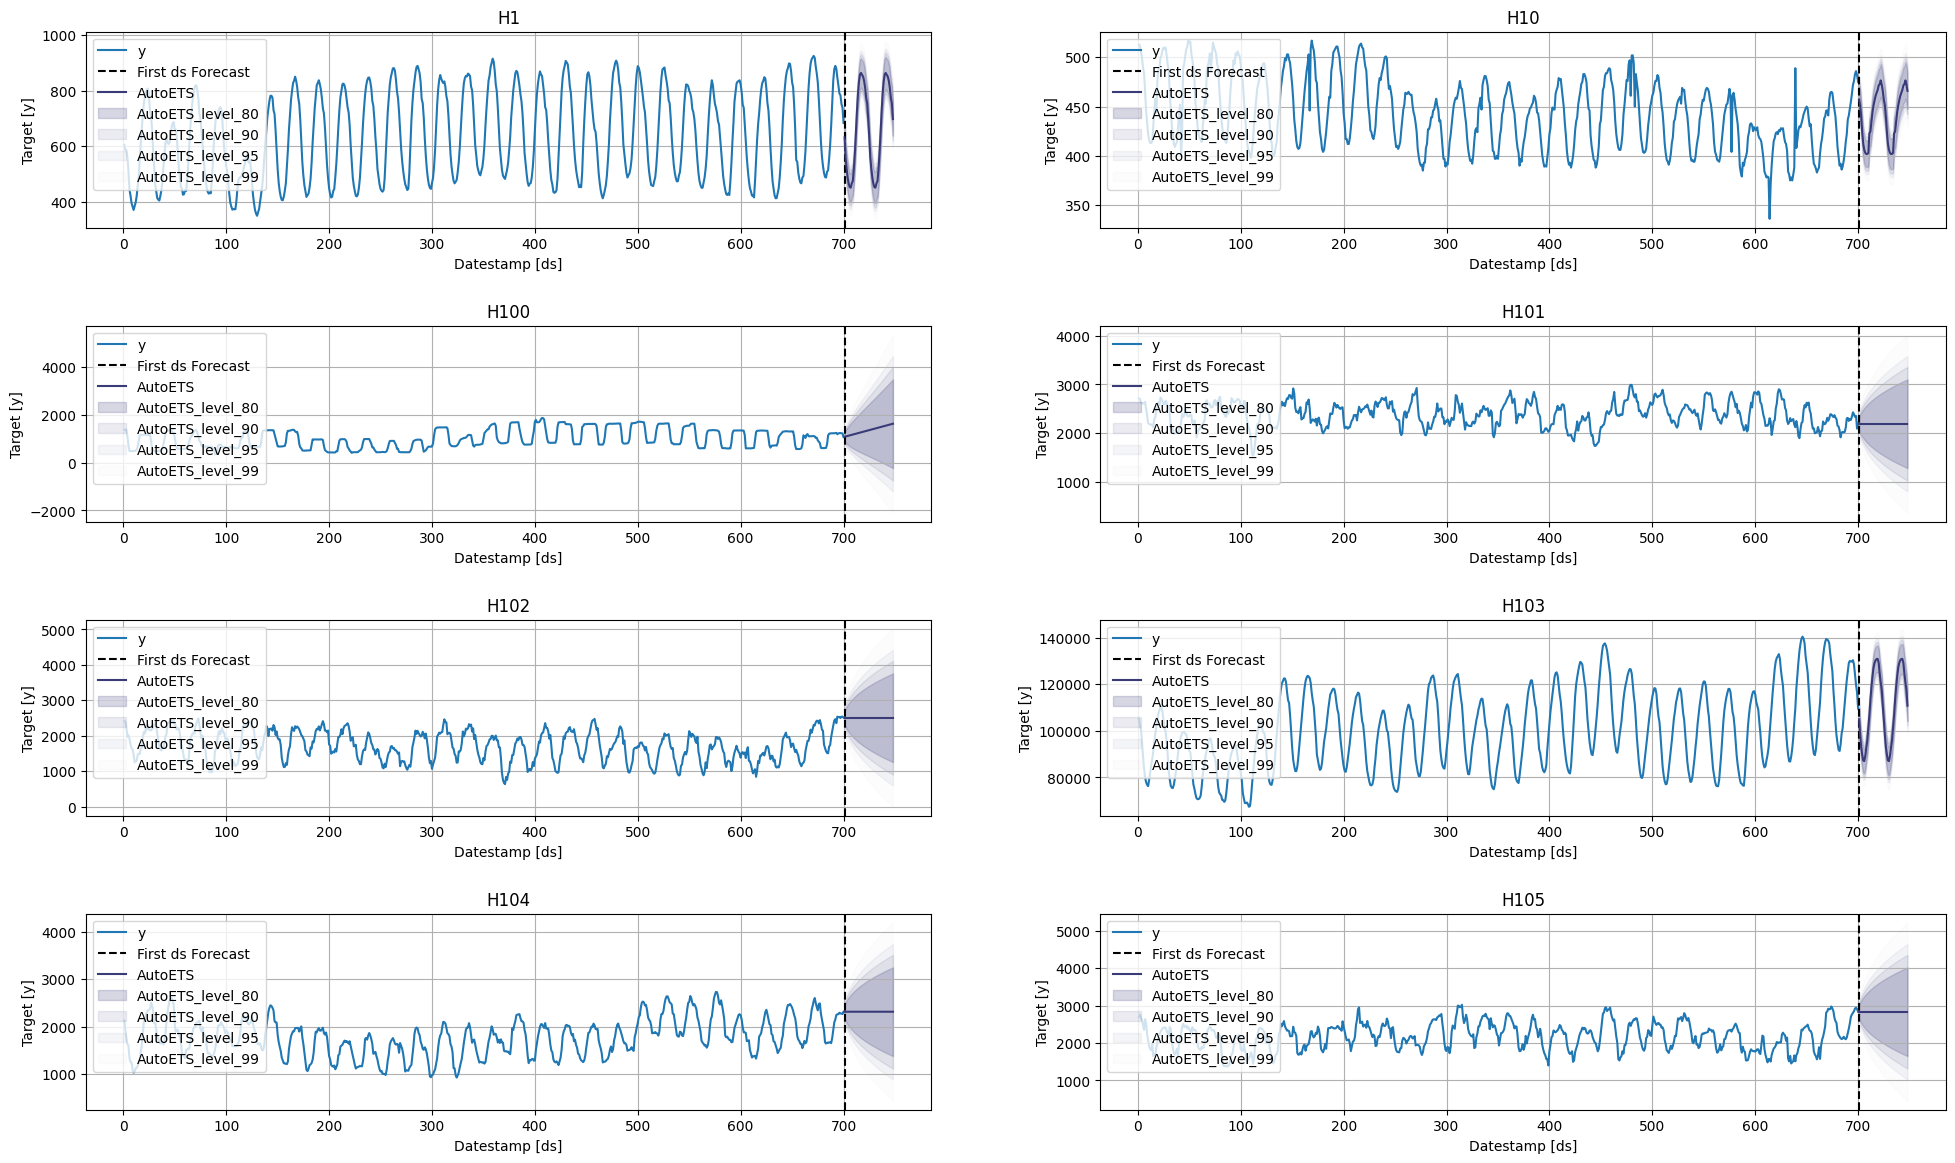

In [14]:
sf.plot(train, test, plot_random = False, models=['AutoETS'], level=levels)

### Historic Average

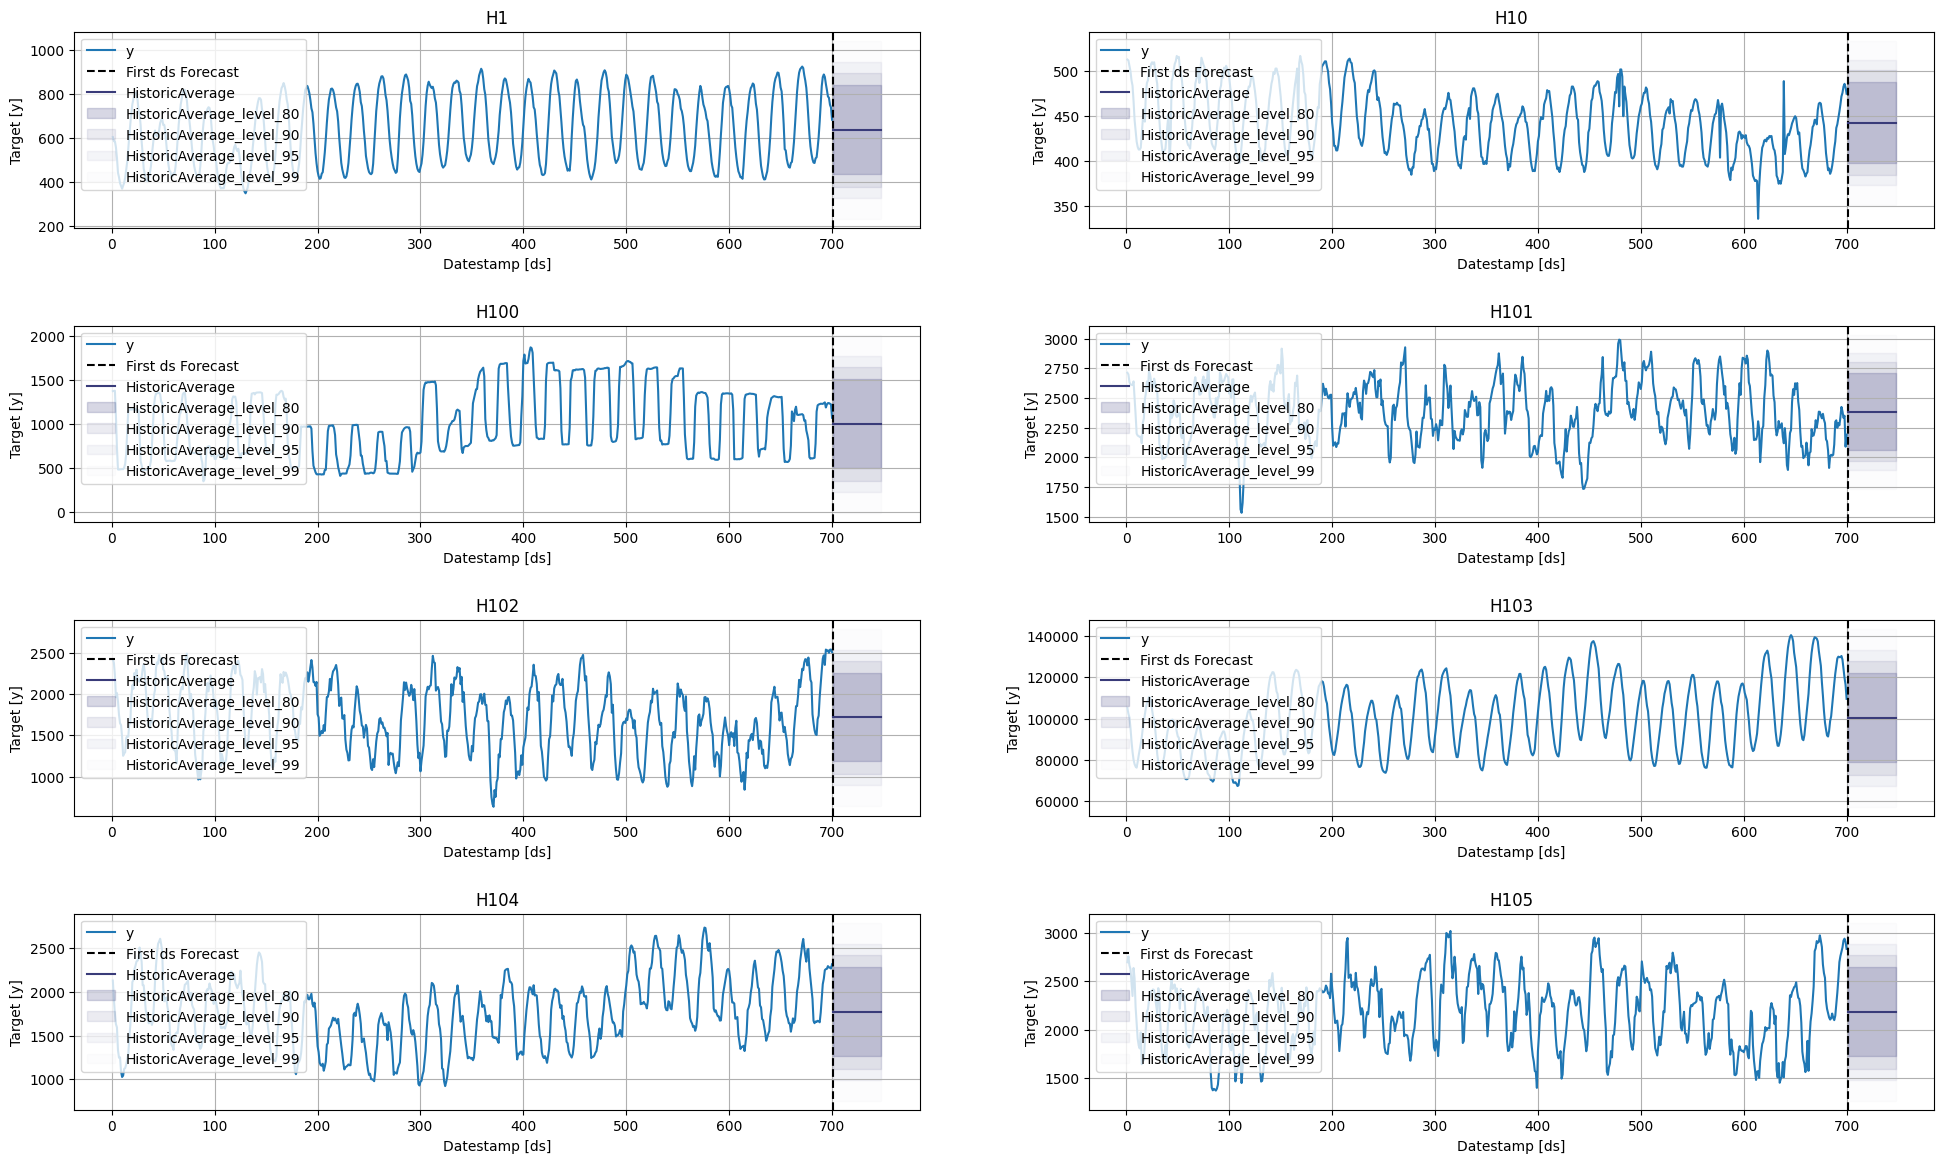

In [15]:
sf.plot(train, test, plot_random = False, models=['HistoricAverage'], level=levels)

### Naive

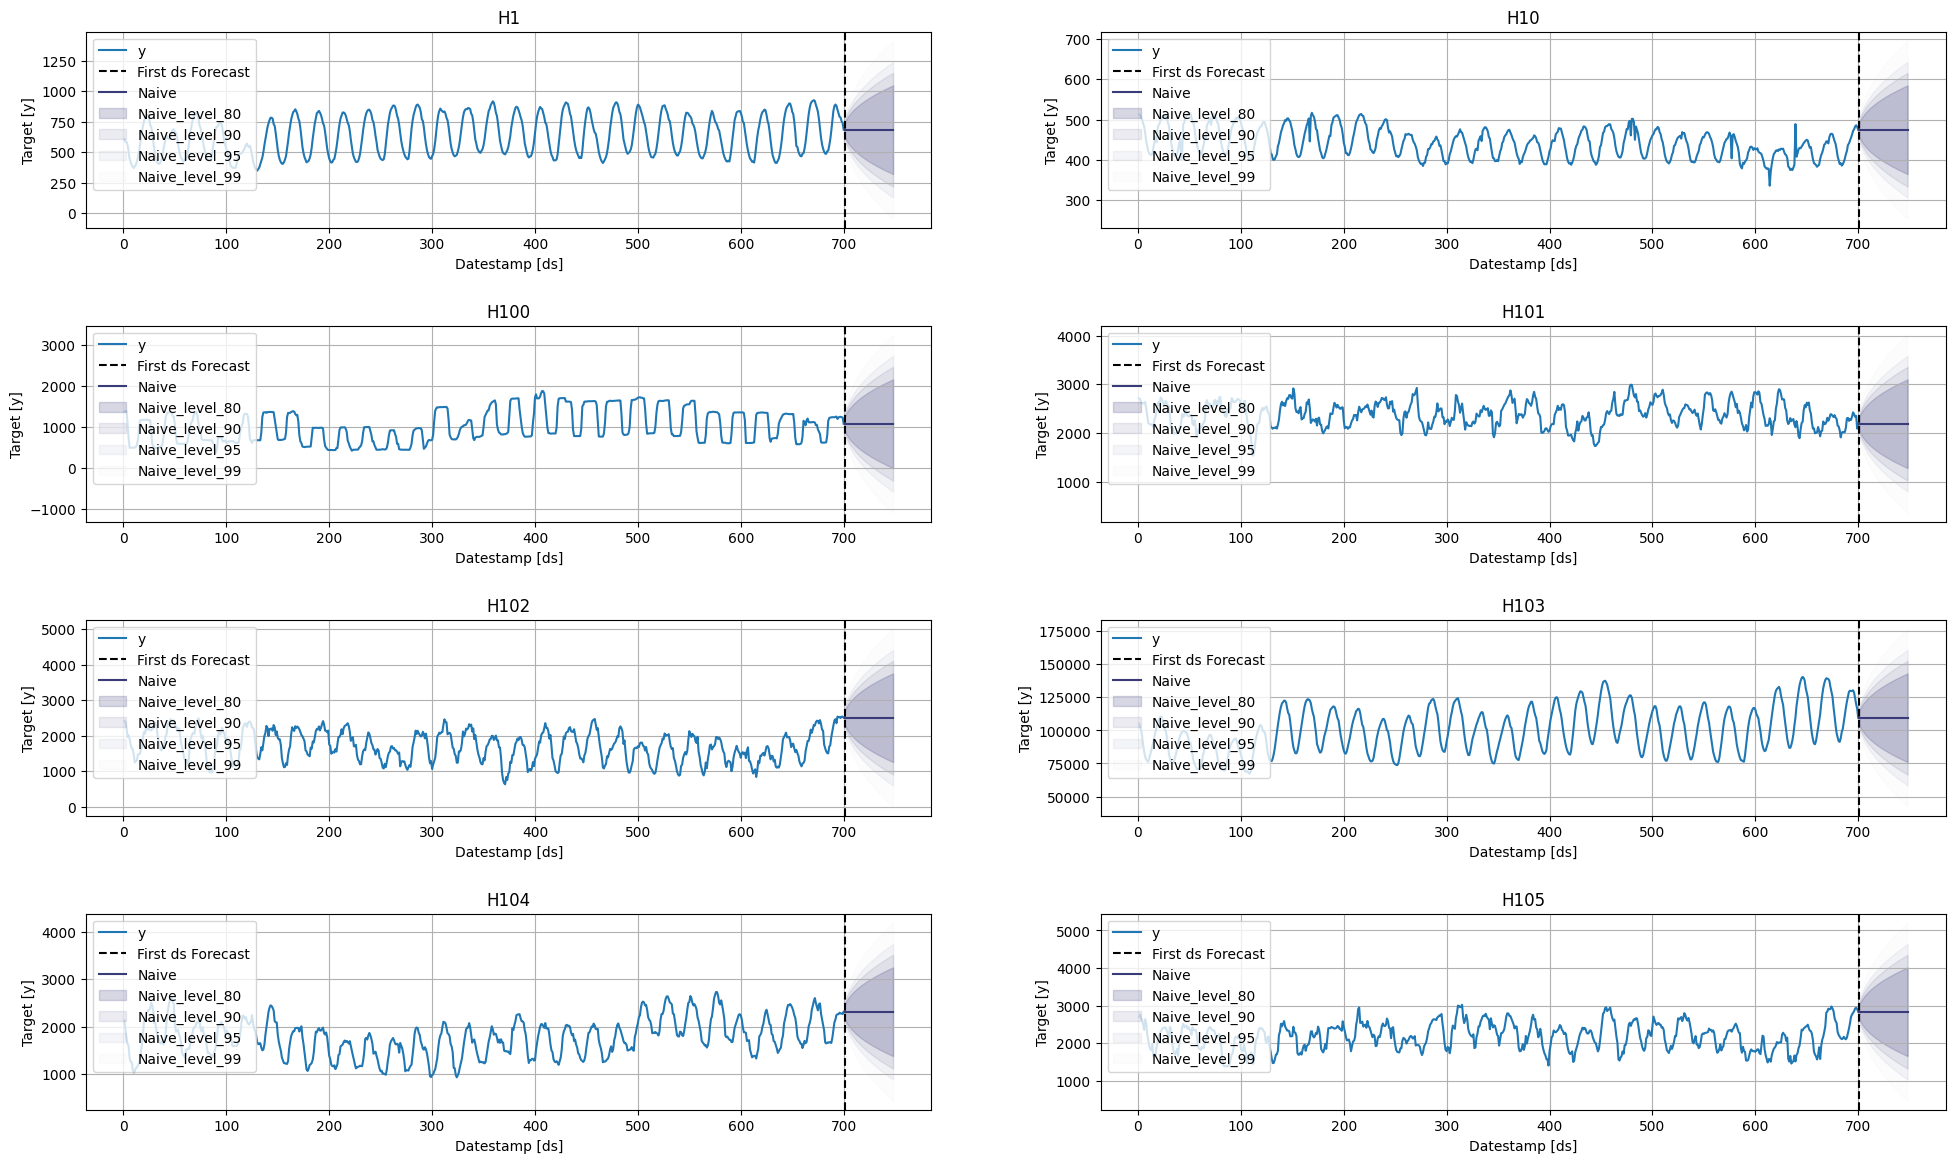

In [16]:
sf.plot(train, test, plot_random = False, models=['Naive'], level=levels)

### Random Walk with Drift

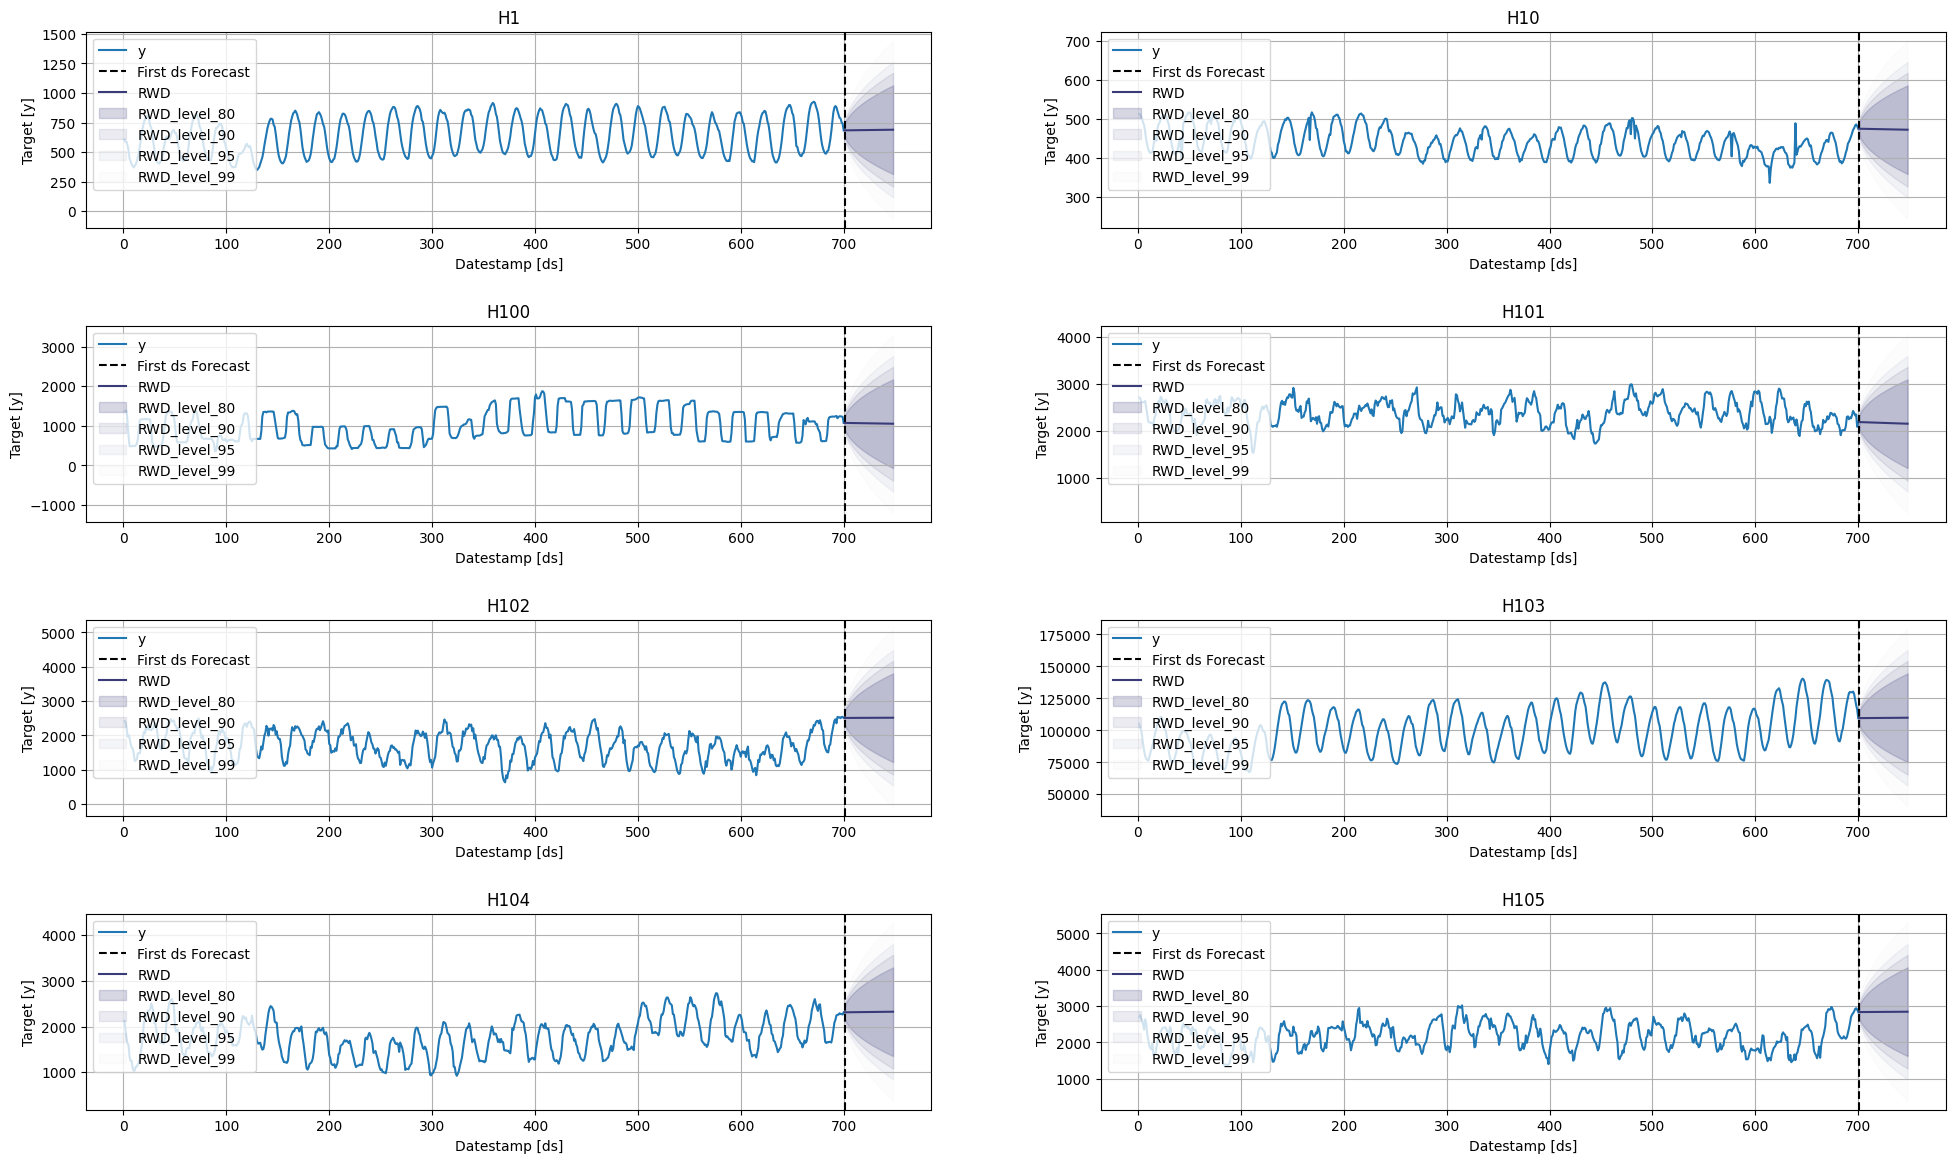

In [17]:
sf.plot(train, test, plot_random = False, models=['RWD'], level=levels)

### Seasonal Naive

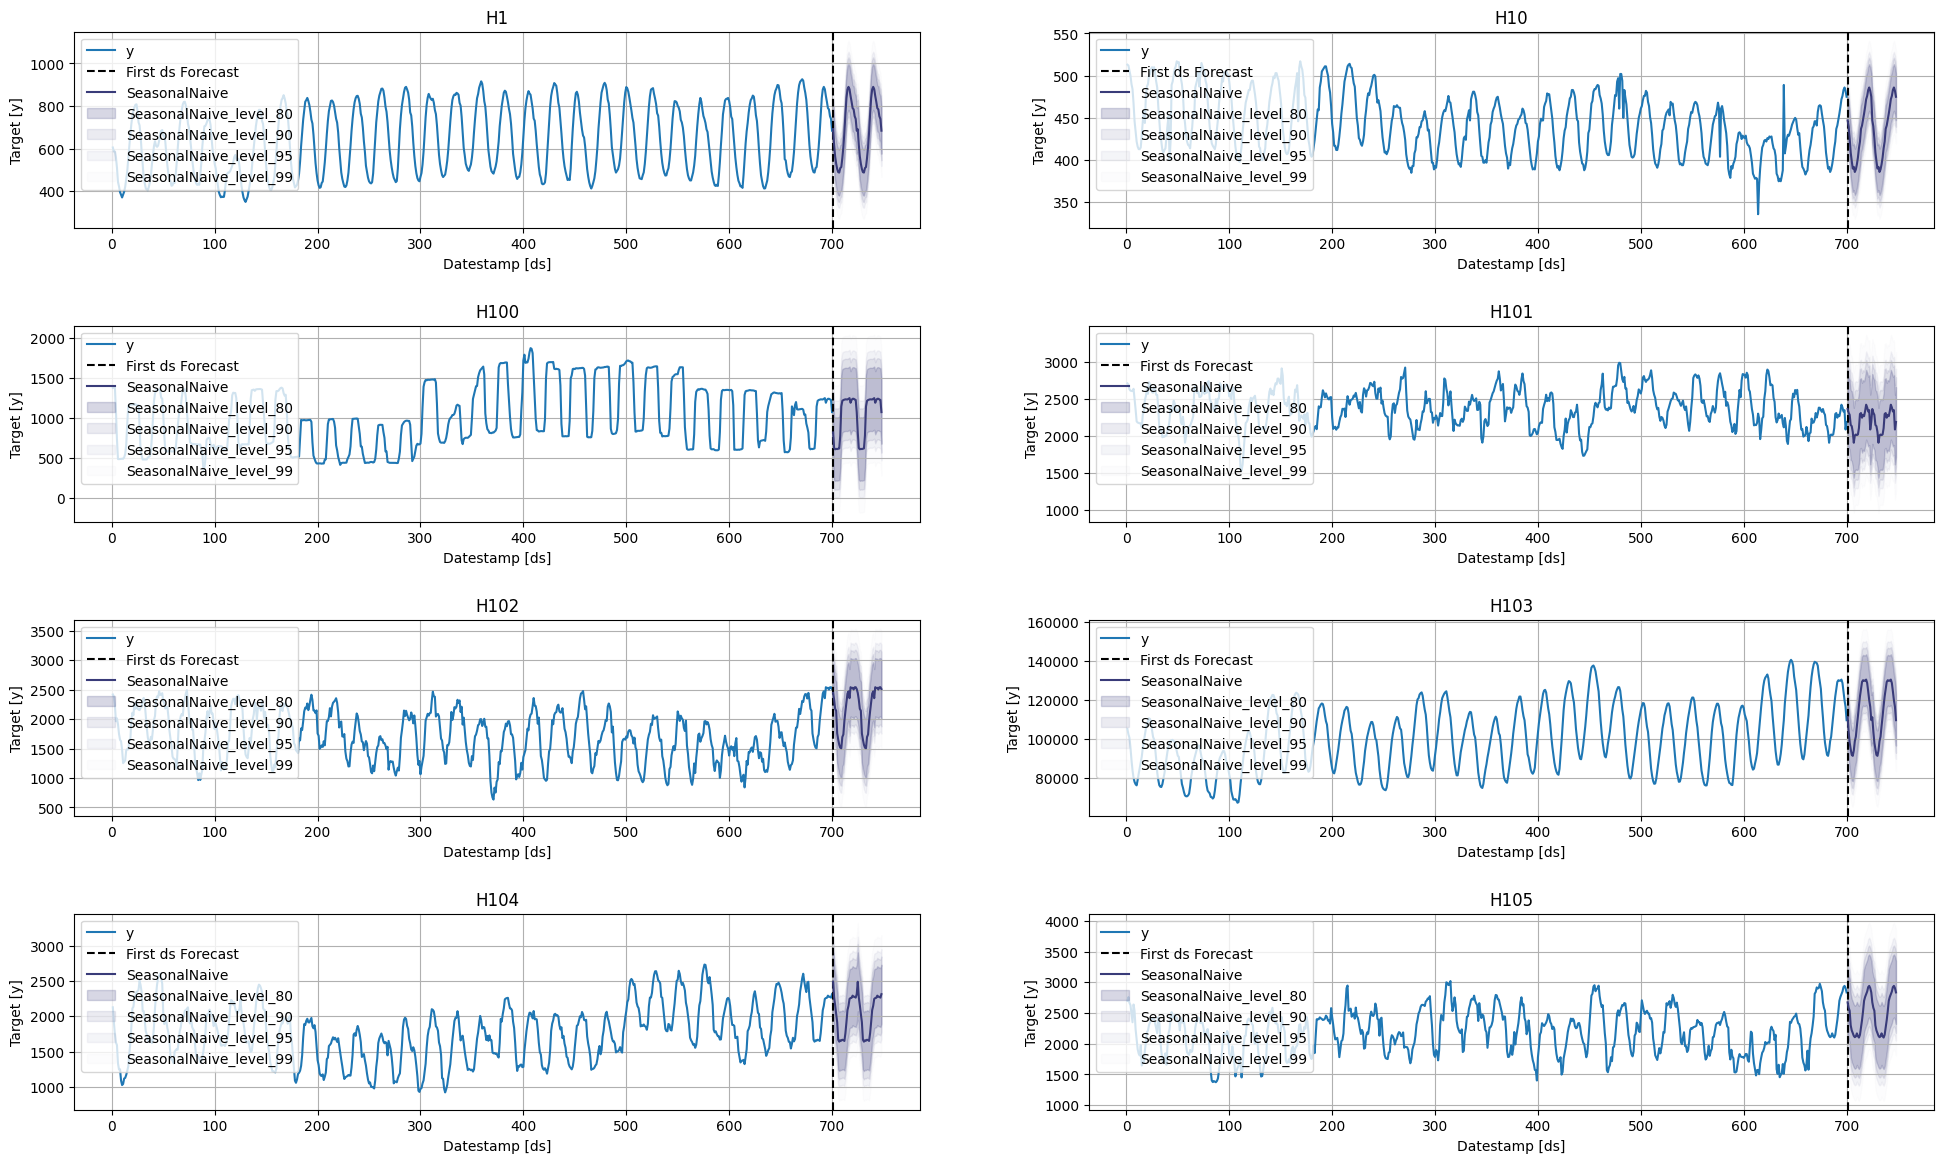

In [18]:
sf.plot(train, test, plot_random = False, models=['SeasonalNaive'], level=levels)

From these plots, we can conclude that the uncertainty around each forecast varies according to the model that is being used. For the same time series, one model can predict a wider range of possible future values than others.

# Conformal Prediction with Nixtla

Multi-quantile losses and statistical models can provide provide prediction intervals, but the problem is that these are uncalibrated, meaning that the actual frequency of observations falling within the interval does not align with the confidence level associated with it. For example, a calibrated 95% prediction interval should contain the true value 95% of the time in repeated sampling. An uncalibrated 95% prediction interval, on the other hand, might contain the true value only 80% of the time, or perhaps 99% of the time. In the first case, the interval is too narrow and underestimates the uncertainty, while in the second case, it is too wide and overestimates the uncertainty.

Statistical methods also assume normality. Here, we talk about another method called conformal prediction that doesn’t require any distributional assumptions. More information on the approach can be found in this Awesome Conformal Prediction repo https://github.com/valeman/awesome-conformal-prediction.

Conformal prediction intervals use cross-validation on a point forecaster model to generate the intervals. This means that no prior probabilities are needed, and the output is well-calibrated. No additional training is needed, and the model is treated as a black box. The approach is compatible with any model.

Statsforecast now supports Conformal Prediction on all available models.

## Train models

StatsForecast can train multiple models on different time series efficiently. Most of these models can generate a probabilistic forecast, which means that they can produce both point forecasts and prediction intervals.

For this example, we’ll use SimpleExponentialSmoothing and ADIDA which do not provide a prediction interval natively. Thus, it makes sense to use Conformal Prediction to generate the prediction interval.

We’ll also show using it with ARIMA to provide prediction intervals that don’t assume normality.

To use these models, we first need to import them from statsforecast.models and then we need to instantiate them.

In [20]:
# Create a list of models and instantiation parameters
intervals = ConformalIntervals(h=24, n_windows=2)

models = [
    SeasonalExponentialSmoothing(season_length=24,alpha=0.1, prediction_intervals=intervals),
    ADIDA(prediction_intervals=intervals),
    ARIMA(order=(24,0,12), season_length=24, prediction_intervals=intervals),
]

In [19]:
??ConformalIntervals

In [21]:
sf = StatsForecast(
    df=train,
    models=models,
    freq='H',
)

In [22]:
levels = [80, 90] # confidence levels of the prediction intervals

forecasts = sf.forecast(h=24, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

unique_id   ds  SeasonalES  SeasonalES-lo-90  SeasonalES-lo-80  \
0        H1  701  624.132690        561.315369        565.365356   
1        H1  702  555.698181        501.886902        510.377441   
2        H1  703  514.403015        468.656036        471.506042   
3        H1  704  482.057892        438.715790        442.315796   
4        H1  705  460.222534        419.595062        422.745056   

   SeasonalES-hi-80  SeasonalES-hi-90       ADIDA  ADIDA-lo-90  ADIDA-lo-80  \
0        682.900024        686.950012  747.292542   668.049988   672.099976   
1        601.018921        609.509460  747.292542   560.200012   570.400024   
2        557.299988        560.150024  747.292542   546.849976   549.700012   
3        521.799988        525.400024  747.292542   508.600006   512.200012   
4        497.700012        500.850006  747.292542   486.149994   489.299988   

   ADIDA-hi-80  ADIDA-hi-90       ARIMA  ARIMA-lo-90  ARIMA-lo-80  \
0   822.485107   826.535095  623.806885   560.663757   564.713806   
1   924.185059   934.385071  561.464783   511.690125   518.450684   
2   944.885071   947.735107  521.422424   482.694824   485.544800   
3   982.385071   985.985107  497.420807   469.441589   473.041595   
4  1005.285095  1008.435059  480.431122   460.012207   463.162231   

   ARIMA-hi-80  ARIMA-hi-90  
0   682.900024   686.950012  
1   604.478882   611.239441  
2   557.299988   560.150024  
3   521.799988   525.400024  
4   497.700012   500.850006

### Plot prediction intervals

In [23]:
def _plot_fcst(fcst, train, model):
    fig, ax = plt.subplots(1, 1, figsize = (20,7))
    plt.plot(np.arange(0, len(train['y'])), train['y'])
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[model], label=model)
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-90'], color = 'r', label='lo-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-90'], color = 'r', label='hi-90')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-lo-80'], color = 'g', label='lo-80')
    plt.plot(np.arange(len(train['y']), len(train['y']) + 24), fcst[f'{model}-hi-80'], color = 'g', label='hi-80')
    plt.legend()

In [24]:
id = "H105"
temp_train = train.loc[train['unique_id'] == id]
temp_forecast = forecasts.loc[forecasts['unique_id'] == id]

The prediction interval with the SeasonalExponentialSmoothing seen below. Even if the model generates a point forecast, we are able to get a prediction interval. The 80% prediction interval does not cross the 90% prediction interval, which is a sign that the intervals are calibrated.

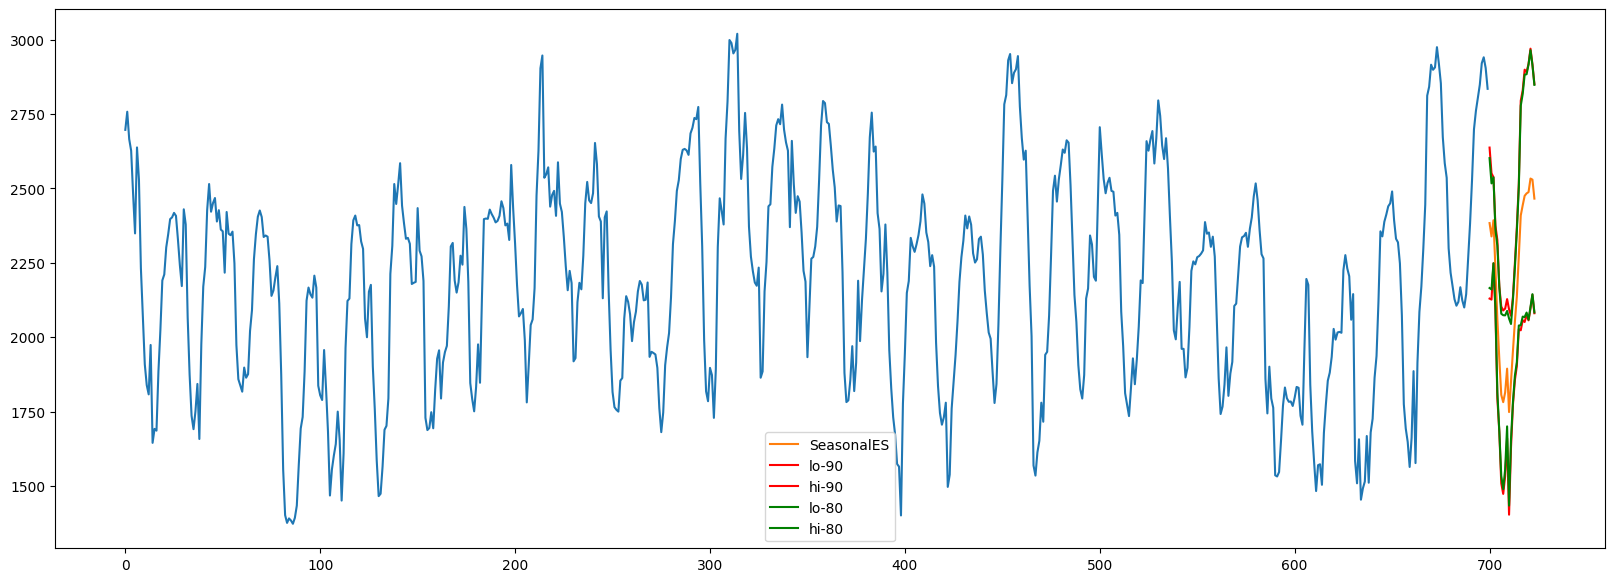

In [25]:
_plot_fcst(temp_forecast, temp_train, "SeasonalES")

For weaker fitting models, the conformal prediction interval can be larger. A better model corresponds to a narrower interval.

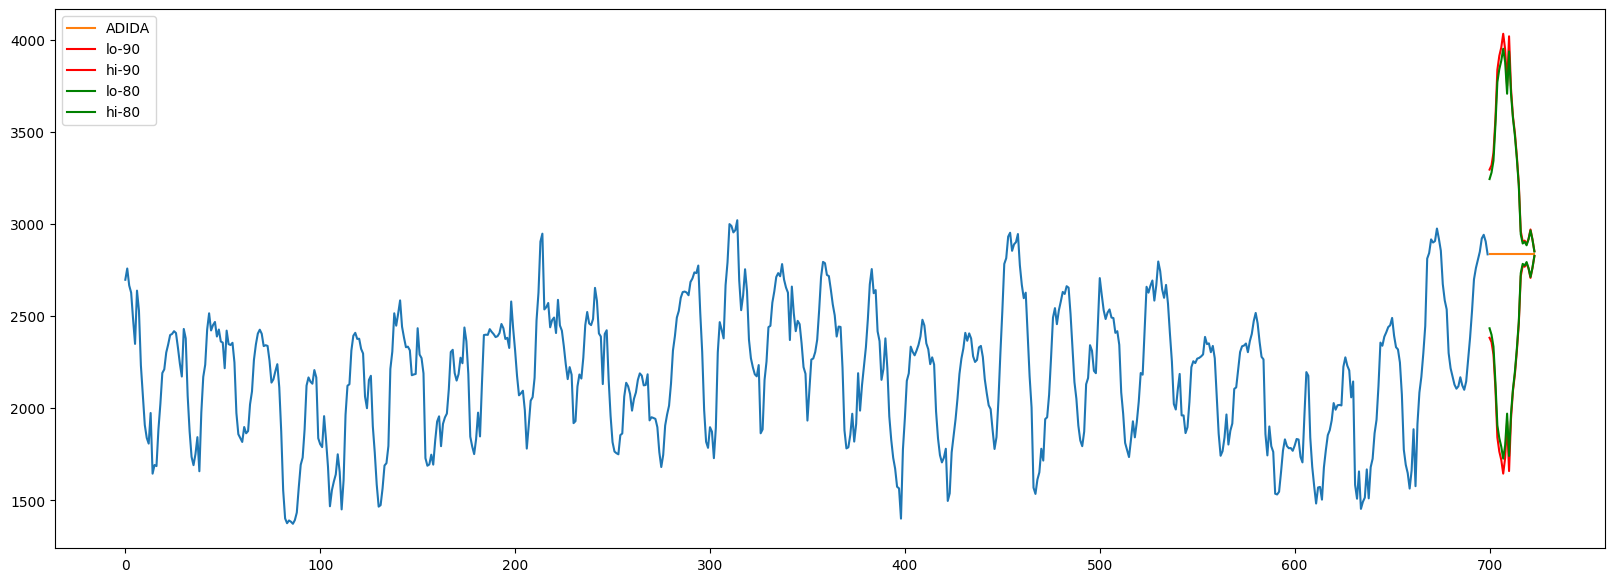

In [26]:
_plot_fcst(temp_forecast, temp_train,"ADIDA")

ARIMA is an example of a model that provides a forecast distribution, but we can still use conformal prediction to generate the prediction interval. As mentioned earlier, this method has the benefit of not assuming normality.

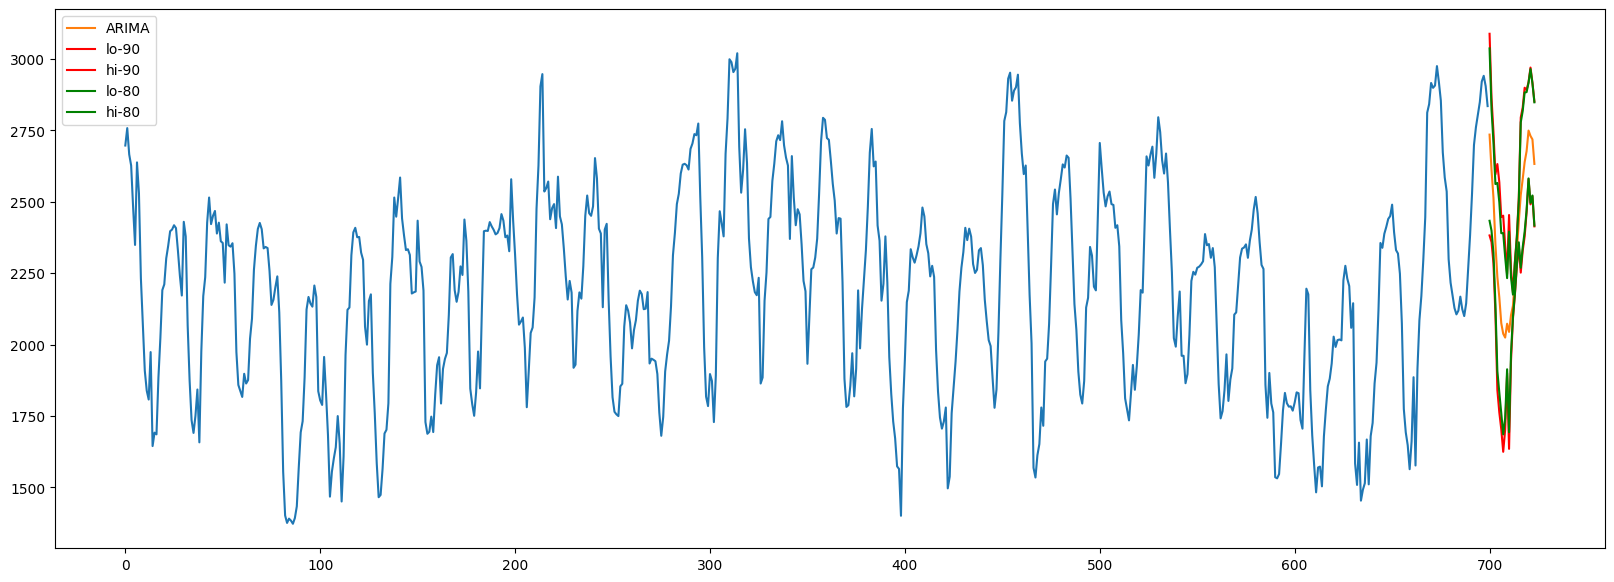

In [27]:
_plot_fcst(temp_forecast, temp_train,"ARIMA")

In [29]:
temp_train

unique_id   ds       y
4900      H105    1  2697.0
4901      H105    2  2758.0
4902      H105    3  2666.0
4903      H105    4  2627.0
4904      H105    5  2482.0
...        ...  ...     ...
5595      H105  696  2849.0
5596      H105  697  2921.0
5597      H105  698  2941.0
5598      H105  699  2905.0
5599      H105  700  2835.0

[700 rows x 3 columns]

In [28]:
temp_forecast

unique_id   ds   SeasonalES  SeasonalES-lo-90  SeasonalES-lo-80  \
168      H105  701  2383.709717       2129.906494       2165.393555   
169      H105  702  2338.826660       2126.605225       2160.557373   
170      H105  703  2393.279541       2248.383789       2248.767822   
171      H105  704  2231.460449       2087.488037       2100.976318   
172      H105  705  2060.562012       1794.368652       1813.737183   
173      H105  706  1926.845825       1682.537842       1684.384155   
174      H105  707  1806.249634       1509.024414       1533.549438   
175      H105  708  1781.764893       1473.500366       1489.470825   
176      H105  709  1814.698364       1533.137207       1555.877686   
177      H105  710  1894.431152       1660.632935       1700.403564   
178      H105  711  1748.479126       1403.564453       1434.170776   
179      H105  712  1850.870728       1629.491455       1657.241455   
180      H105  713  1954.907349       1773.814697       1782.814697   
181      H105  714  2053.192627       1856.485229       1870.585205   
182      H105  715  2136.817383       1903.534790       1916.434814   
183      H105  716  2271.371094       2027.042236       2039.342163   
184      H105  717  2409.197021       2023.343994       2040.294067   
185      H105  718  2443.519043       2057.187988       2069.338135   
186      H105  719  2475.318115       2051.286133       2067.936279   
187      H105  720  2483.468994       2075.437988       2082.937988   
188      H105  721  2487.828857       2056.757812       2058.857666   
189      H105  722  2533.341064       2096.782227       2101.882080   
190      H105  723  2529.750000       2142.600098       2144.699951   
191      H105  724  2465.933105       2080.716309       2083.566162   

     SeasonalES-hi-80  SeasonalES-hi-90        ADIDA  ADIDA-lo-90  \
168       2602.025879       2637.512939  2838.474854  2382.300049   
169       2517.095947       2551.048096  2838.474854  2358.899902   
170       2537.791260       2538.175293  2838.474854  2291.199951   
171       2361.944580       2375.432861  2838.474854  2107.750000   
172       2307.386719       2326.755371  2838.474854  1841.300049   
173       2169.307617       2171.153809  2838.474854  1765.000000   
174       2078.949707       2103.474854  2838.474854  1720.000000   
175       2074.058838       2090.029541  2838.474854  1645.300049   
176       2073.519043       2096.259521  2838.474854  1730.550049   
177       2088.458740       2128.229248  2838.474854  1928.300049   
178       2062.787598       2093.393799  2838.474854  1659.050049   
179       2044.500000       2072.250000  2838.474854  1942.750000   
180       2127.000000       2136.000000  2838.474854  2094.000000   
181       2235.800049       2249.899902  2838.474854  2184.100098   
182       2357.199951       2370.100098  2838.474854  2309.899902   
183       2503.399902       2515.699951  2838.474854  2458.300049   
184       2778.100098       2795.050049  2838.474854  2715.949951   
185       2817.699951       2829.850098  2838.474854  2772.092529   
186       2882.699951       2899.350098  2838.474854  2767.557129   
187       2884.000000       2891.500000  2838.474854  2785.449707   
188       2916.800049       2918.899902  2838.474854  2758.049805   
189       2964.800049       2969.899902  2838.474854  2707.049805   
190       2914.800049       2916.899902  2838.474854  2760.049805   
191       2848.300049       2851.149902  2838.474854  2824.757324   

     ADIDA-lo-80  ADIDA-hi-80  ADIDA-hi-90        ARIMA  ARIMA-lo-90  \
168  2433.600098  3243.349609  3294.649658  2735.235352  2382.300049   
169  2398.800049  3278.149658  3318.049805  2611.418701  2358.899902   
170  2334.399902  3342.549805  3385.749756  2514.670166  2284.801025   
171  2141.500000  3535.449707  3569.199707  2351.849854  2107.750000   
172  1907.599976  3769.349609  3835.649658  2236.714844  1841.300049   
173  1837.000000  3839.949707  3911.949707  2165.690674  1762.807129  

In [34]:
arima_forecast_dfarima_forecast_df = temp_forecast[['unique_id',	'ds', 'ARIMA',	'ARIMA-lo-90', 'ARIMA-hi-90']]
.head()

unique_id   ds        ARIMA  ARIMA-lo-90  ARIMA-hi-90
168      H105  701  2735.235352  2382.300049  3088.170898
169      H105  702  2611.418701  2358.899902  2863.937500
170      H105  703  2514.670166  2284.801025  2744.539307
171      H105  704  2351.849854  2107.750000  2595.949707
172      H105  705  2236.714844  1841.300049  2632.129883

In [37]:
temp_train.to_csv('temp_train.csv')

In [38]:
arima_forecast_df.to_csv('arima_forecast_df.csv')

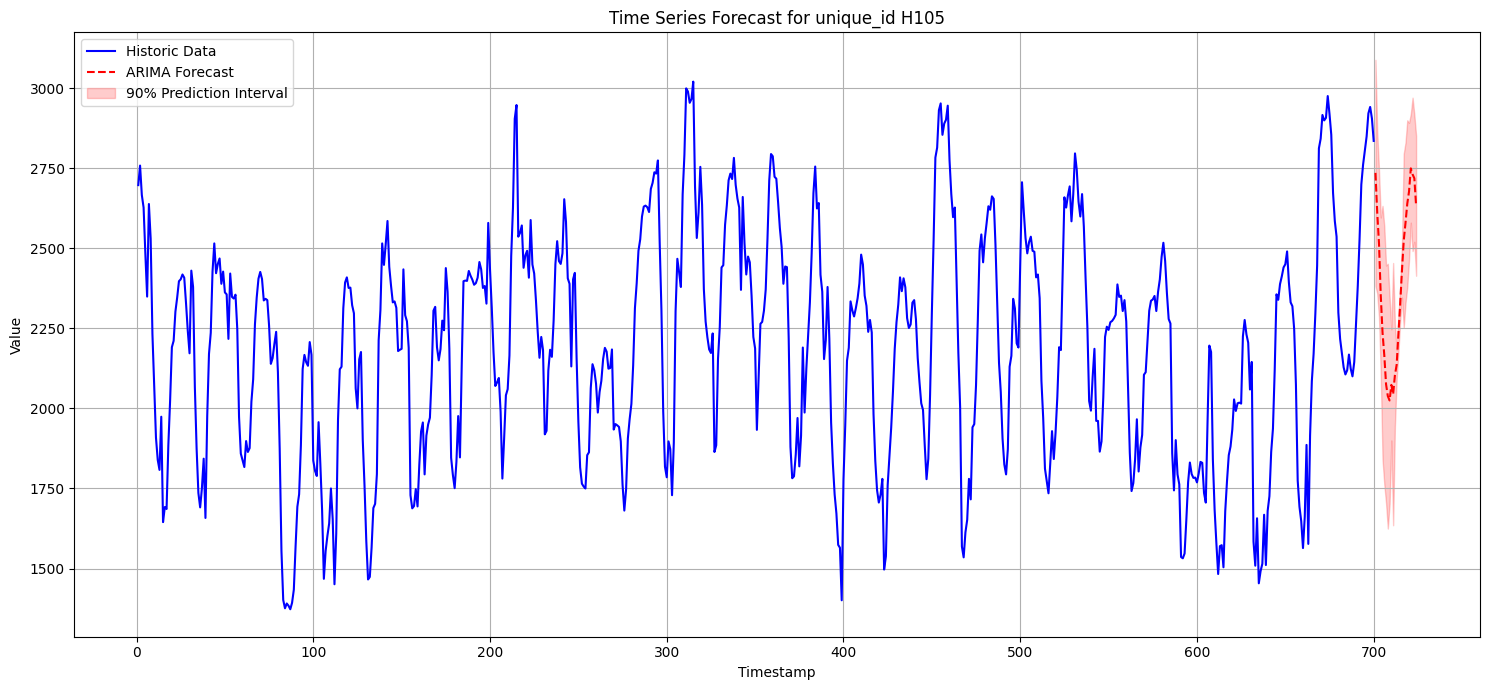

In [39]:
# Ensure data is sorted by 'ds'
temp_train = temp_train.sort_values(by='ds')
arima_forecast_df = arima_forecast_df.sort_values(by='ds')

# Let's visualize for a sample unique_id for clarity. We'll pick the first unique_id for demonstration.
sample_id = temp_train['unique_id'].iloc[0]

temp_train_sample = temp_train[temp_train['unique_id'] == sample_id]
arima_forecast_sample = arima_forecast_df[arima_forecast_df['unique_id'] == sample_id]

# Plot
plt.figure(figsize=(15, 7))
plt.plot(temp_train_sample['ds'], temp_train_sample['y'], label='Historic Data', color='blue')
plt.plot(arima_forecast_sample['ds'], arima_forecast_sample['ARIMA'], label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(arima_forecast_sample['ds'], arima_forecast_sample['ARIMA-lo-90'], arima_forecast_sample['ARIMA-hi-90'], color='red', alpha=0.2, label='90% Prediction Interval')
plt.legend()
plt.title(f"Time Series Forecast for unique_id {sample_id}")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()